In [1]:
import numpy as np
import pyopencl as cl
from PIL import Image
from IPython.display import display, clear_output

In [2]:
from clutil import *
from compute import *

%load_ext autoreload
%autoreload 2

In [3]:
def display_depth(depth_buffer, max_depth):
    display(Image.fromarray((255*np.log(np.maximum(depth_buffer, 0) + 1)/np.log(max_depth + 1)).astype(np.uint8)))

def display_color(color_buffer):
    display(Image.fromarray((255*color_buffer).astype(np.uint8)))

In [4]:
ctx = cl.create_some_context()

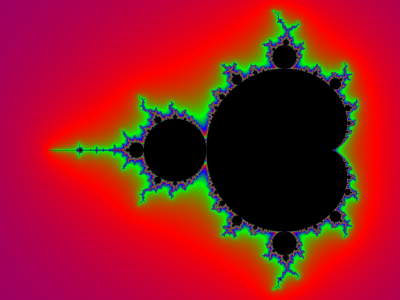

In [12]:
scene = Scene(ctx, (1600, 1200), scale=4)
scene.compute((-0.8, 0), (2.4, 0), max_depth=1024)
display_color(scene.colorize([[1,0,0,1], [0,1,0,1], [0,0,1,1]], period=20))

In [13]:
tiny_scene = Scene(ctx, (480, 420), scale=1)

In [14]:
search(tiny_scene, n=3, max_depth=256)

array([[-1.62285714, -0.07428571],
       [ 0.47428571, -0.26857143],
       [ 0.01714286,  0.93142857]])

In [15]:
temp = (0.2, 0.075)

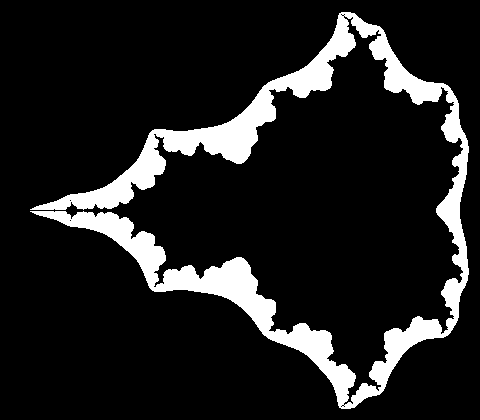

In [16]:
field = np.zeros(tiny_scene.shape, dtype=np.uint8).reshape(-1)
points = search(tiny_scene, n=1000000, temp=temp, pix=True)
points = points[:,0] + points[:,1]*tiny_scene.shape[1]
field[points] = 255
display(Image.fromarray(field.reshape(*tiny_scene.shape)))

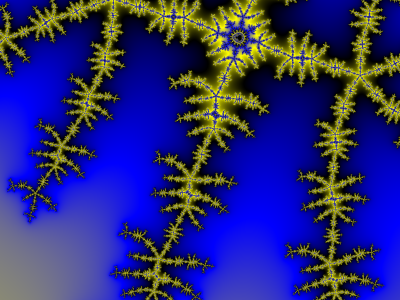

In [17]:
def draw(scene, color_map):
    display_color(scene.colorize(color_map, period=50))

color_map = [[0,0,0,1], [1,1,0,1], [0,0,1,1]]
md = 1024

for k in range(1):
    pos = search(tiny_scene, max_depth=md, temp=temp)[0]
    #draw(tiny_scene, color_map)
    zoom = 2.0
    for i in range(6):
        zoom /= 4
        pos = search(tiny_scene, pos=pos, zoom=(zoom,0), max_depth=md, temp=temp)[0]
        #draw(tiny_scene, color_map)

    scene.compute(pos, (zoom,0), max_depth=4096)
    draw(scene, color_map)